In [1]:
import json
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary
from GaborNet.gabor import GaborConv2d
#from GaborNet.GaborLayer import GaborConv2d
from dataset import JAFFEDataset



cuda:0


In [2]:
'''
seed = 7
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
'''

'\nseed = 7\ntorch.manual_seed(seed)\ntorch.cuda.manual_seed(seed)\ntorch.cuda.manual_seed_all(seed)\nnp.random.seed(seed)\nrandom.seed(seed)\ntorch.backends.cudnn.benchmark = False\ntorch.backends.cudnn.deterministic = True\n'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [4]:
class GaborNN(nn.Module):
    def __init__(self):
        super(GaborNN, self).__init__()
        self.c1 = GaborConv2d(1, 32, kernel_size=(9, 9))
        self.c2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.fc1 = nn.Linear(64*9*9, 1024)
        self.fc2 = nn.Linear(1024, 7)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = x.view(-1, 64*9*9)
        x = F.relu(self.fc1(x))
        x = nn.Dropout2d()(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [5]:
with open("../params.yaml", "r") as stream:
        try:
            params = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
print(params["sanity_check"]["epoch"])

30


In [6]:
transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((48, 48)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )

In [7]:
jaffe_dir = '../jaffe'
jaffe_dir_list = os.listdir(jaffe_dir)
train_set = JAFFEDataset(root_dir=jaffe_dir, transform=transform)

In [8]:
train = DataLoader(train_set, batch_size=7, num_workers=0, shuffle=True) 


In [9]:
net = GaborNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
print(net)

GaborNN(
  (c1): GaborConv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), bias=False)
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
)


In [10]:
summary(net, (16, 1, 48, 48))

C:\Users\G35CG SKU3\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
GaborNN                                  --                        --
├─GaborConv2d: 1-1                       [16, 32, 40, 40]          2,720
├─Conv2d: 1-2                            [16, 64, 18, 18]          18,496
├─Linear: 1-3                            [16, 1024]                5,309,440
├─Linear: 1-4                            [16, 7]                   7,175
Total params: 5,337,831
Trainable params: 5,337,831
Non-trainable params: 0
Total mult-adds (M): 247.30
Input size (MB): 0.15
Forward/backward pass size (MB): 9.34
Params size (MB): 21.35
Estimated Total Size (MB): 30.84

In [11]:
one_layer_gnet_acc_train = []
time_per_image_train = []

In [12]:
for epoch in range(params["sanity_check"]["epoch"]):

    running_loss = 0.0
    correct = 0
    net.train()
    start = time.perf_counter()
    for data in train:
        # get the inputs
        inputs, labels = data["image"], data["target"]
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        pred = outputs.max(1, keepdim=True)[1].to("cpu")
        correct += pred.eq(labels.view_as(pred)).sum().item()

        # print statistics
        running_loss += loss.item()
    finish = time.perf_counter()
    time_per_image_train.append((finish - start) / len(train_set))
    print(
        "[%d] train_acc: %.4f train_loss: %.4f"
        % (epoch + 1, correct / len(train_set), running_loss / len(train_set))
    )
    one_layer_gnet_acc_train.append(correct / len(train_set))
print("Finished Training")


[1] train_acc: 0.0986 train_loss: 0.2836
[2] train_acc: 0.1455 train_loss: 0.2831
[3] train_acc: 0.1784 train_loss: 0.2825
[4] train_acc: 0.1972 train_loss: 0.2804
[5] train_acc: 0.2911 train_loss: 0.2739
[6] train_acc: 0.3146 train_loss: 0.2685
[7] train_acc: 0.3521 train_loss: 0.2622
[8] train_acc: 0.4413 train_loss: 0.2566
[9] train_acc: 0.4695 train_loss: 0.2484
[10] train_acc: 0.5164 train_loss: 0.2428
[11] train_acc: 0.5164 train_loss: 0.2399
[12] train_acc: 0.6056 train_loss: 0.2299
[13] train_acc: 0.6948 train_loss: 0.2237
[14] train_acc: 0.7324 train_loss: 0.2149
[15] train_acc: 0.7136 train_loss: 0.2147
[16] train_acc: 0.8169 train_loss: 0.2046
[17] train_acc: 0.8357 train_loss: 0.2012
[18] train_acc: 0.8685 train_loss: 0.1957
[19] train_acc: 0.8638 train_loss: 0.1953
[20] train_acc: 0.8826 train_loss: 0.1939
[21] train_acc: 0.8779 train_loss: 0.1911
[22] train_acc: 0.9108 train_loss: 0.1869
[23] train_acc: 0.9014 train_loss: 0.1887
[24] train_acc: 0.9531 train_loss: 0.1825
[

In [13]:
print("Gabor CNN_Accuaracy:", one_layer_gnet_acc_train[-1])
print("time_per_image_train:", sum(time_per_image_train) / len(time_per_image_train) )

Gabor CNN_Accuaracy: 0.971830985915493
time_per_image_train: 0.004870057668231623


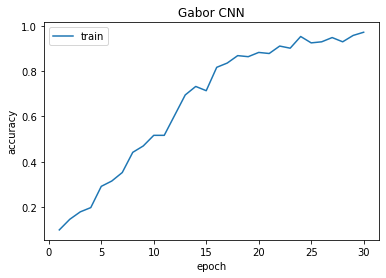

In [14]:
xpt = []
for i in range(params["sanity_check"]["epoch"]):
  i+=1
  xpt.append(i)

plt.title('Gabor CNN')
plt.xlabel('epoch')
plt.ylabel('accuracy')
Data_2, = plt.plot(xpt, one_layer_gnet_acc_train, label ='train')
plt.legend()
plt.show()

Text(0.5, 15.0, 'Prediction')

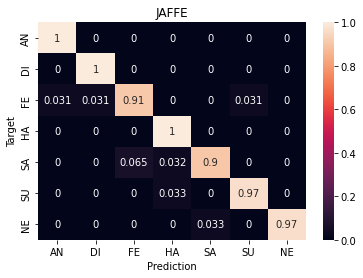

In [24]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in train:
        inputs, classes = data["image"], data["target"]
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

confusion_matrix_array = confusion_matrix.numpy()
conf_mat_arr_normalized = confusion_matrix_array.astype('float') / confusion_matrix_array.sum(axis=1)[:, np.newaxis]
labels_name = ['AN', 'DI', 'FE', 'HA', 'SA', 'SU', 'NE']
df_cm_nor = pd.DataFrame(conf_mat_arr_normalized, index=[i for i in labels_name],columns = [i for i in labels_name])
sn.heatmap(df_cm_nor, annot=True)
plt.title('JAFFE')
plt.ylabel('Target')
plt.xlabel('Prediction')
#plt.savefig('../Confusion_matrix.png')


In [16]:
model_weights = [] 
conv_layers = [] 
model_children = list(net.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
    elif type(model_children[i])== GaborConv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])

print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [17]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: GaborConv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([32, 1, 9, 9])
CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 3, 3])


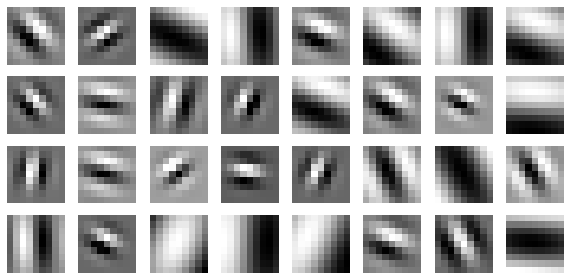

In [18]:
# visualize the first conv layer filters
plt.figure(figsize=(10, 10))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # we have 3x3 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    #plt.savefig('filter1.png')
plt.show()

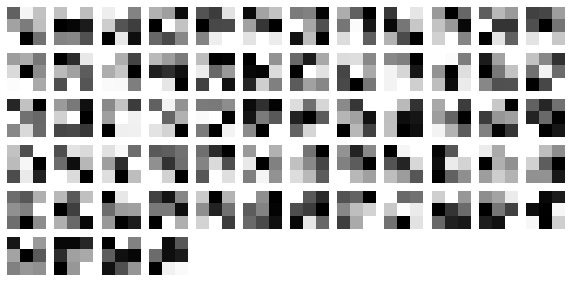

In [19]:
# visualize the first conv layer filters
plt.figure(figsize=(10, 10))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(12, 12, i+1) # we have 3x3 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    #plt.savefig('filter1.png')
plt.show()

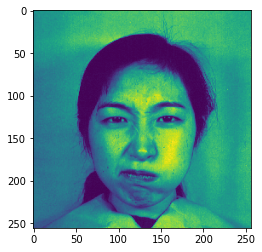

torch.Size([1, 48, 48])
torch.Size([1, 1, 48, 48])


In [20]:
import cv2 as cv
from PIL import Image

img = cv.imread("../jaffe/KA.AN1.39.tiff")
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((48, 48)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
img = img.to(device)
print(img.size())

In [21]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([32, 40, 40])
Saving layer 0 feature maps...


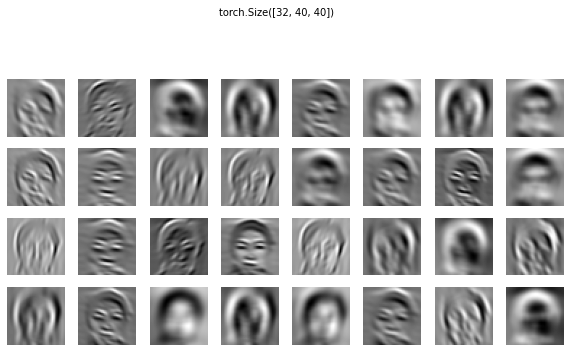

torch.Size([64, 38, 38])
Saving layer 1 feature maps...


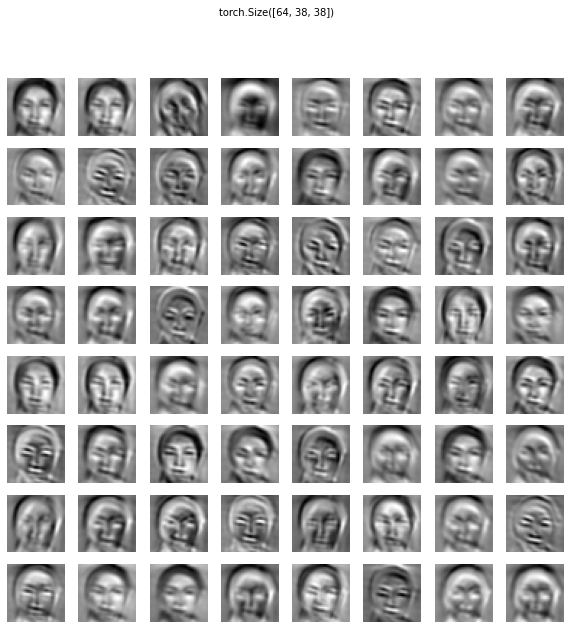

In [22]:
for num_layer in range(len(outputs)):
    fig = plt.figure(figsize=(10, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    fig.suptitle(str(layer_viz.size()), fontsize=10)
    for i, filter in enumerate(layer_viz):
        if i == 64:  # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    #plt.savefig(f"./output/features/dogr400_layer_{num_layer}.png")
    plt.show()
plt.close()